In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [ ]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

In [2]:
path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


In [3]:
columns_to_check = df.columns[:-1]
df_copy = df.copy()
df = df.drop_duplicates(subset=columns_to_check, keep='last')

## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [4]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
VDW              737061
HBOND            694154
PIPISTACK         15091
PICATION           3222
IONIC              1432
SSBOND              729
PIHBOND             722
Name: count, dtype: int64


In [5]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_27470/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [6]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [7]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          15355
s_psi           5727
s_3di_state    31563
t_rsa             73
t_phi           5556
t_psi          18133
t_3di_state    37305
dtype: int64

Total missing values: 113775


Dropping the rows with missing values

In [8]:
# Count initial shape of X and y
print(f"Initial shape - X: {X.shape}, y: {y.shape}")

# Identify rows with any missing values
rows_with_missing = X.isna().any(axis=1)
print(f"Found {rows_with_missing.sum()} rows with missing values")

# Keep track of the indices we're keeping
valid_indices = ~rows_with_missing

# Apply the same filtering to both X and y to keep them aligned
X = X[valid_indices]
y = y[valid_indices]  # Make sure to filter y as well!

# Verify the new shape
print(f"New shape after removing rows - X: {X.shape}, y: {y.shape}")

# Double-check no missing values remain
total_missing = X.isna().sum().sum()
print(f"Total missing values after deletion: {total_missing}\n")

Initial shape - X: (2541958, 20), y: (2541958,)
Found 66745 rows with missing values
New shape after removing rows - X: (2475213, 20), y: (2475213,)
Total missing values after deletion: 0



Filling the rows with missing values with the mean of the values of that column

In [ ]:
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

## Feature engineering


*   Sum
*   Product
*   Absolute difference
*   Average



In [9]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names


In [10]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

for feature in features:
  feature_names.extend(fe(feature))

Engineering feature: ss8_encoded
   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   ...   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  t_ss8_encoded  \
0  ...  0.533 -0.277  1.648          6.0              3              7   
1  ... -0.862 -1.020 -0.255          4.0              0              1   
2  ... -3.005 -0.503 -1.853          2.0              2              0   
3  ... -4.760  0.670 -2.647         17.0              4              4   
4  ...  1.477  0.113 -0.837         13.0              0              3   

   ss8_encoded_sum  ss8_encoded_abs

## Scaling features

In [11]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [13]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 432384
1: 458843
2: 9454
3: 883
4: 2003
5: 450
6: 444
7: 679675


In [14]:
sampling_strategy = {
    0: 432384,  # HBOND
    1: 458843,  # VDW
    2: 9454,  # PIPISTACK
    3: 10000,  # IONIC
    4: 10000,  # PICATION
    5: 5000,  # SSBOND
    6: 5000,  # PIHBOND
    7: 679675   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")


Resampled y_train_bal distribution
0: 432384
1: 458843
2: 9454
3: 10000
4: 10000
5: 5000
6: 5000
7: 679675


In [ ]:
np.save('X_bal.npy', X_train)
np.save('y_bal.npy', y_train)

## XGBoost

### Helper functions

In [15]:
def feature_importance(model, feature_names):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [16]:
import time

def evaluate_model(model, X_test, y_test, feature_names, selected_feature_indices=None):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    """

    # If selected_feature_indices is provided, filter the test data
    if selected_feature_indices is not None:
        X_test = X_test[:, selected_feature_indices]
    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),
            matthews_corrcoef(y_test, y_pred),
            average_precision_score(y_test, y_pred_prob),
            inference_time * 1000,
        ]
    }

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics =====")
    print(metrics_df.set_index('Metric').round(4))

    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"\n===== Feature Importance =====")

    # 8. Feature importance
    feature_importance(model, feature_names)

    return metrics_df, y_pred_prob

### Train loop

In [ ]:
# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

# Train model
model = xgb.train(
    params = {
        'device': 'cuda',
        'seed': 42,
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'eval_metric': 'mlogloss',
        'max_depth': 10,
        'learning_rate': 0.1,
    },
    dtrain=dtrain,
    num_boost_round=2500,
    evals=[(dval, 'mlogloss')],
    early_stopping_rounds=20,
    verbose_eval=100
)

# Save model
os.makedirs(os.path.join(path, 'models/mcc_models'), exist_ok=True)
model.save_model(os.path.join(path, f'models/mcc_models/xgboost_model_mcc.json'))

evaluate_model(model, X_test, y_test, feature_names)


## Pruning models

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict

def analyze_xgboost_model(model_path):
    """Analyze an XGBoost model JSON file and extract useful information."""
    with open(model_path, 'r') as f:
        model_data = json.load(f)

    # Extract basic model information
    results = {}

    # Model metadata and version
    results['version'] = '.'.join(map(str, model_data.get('learner', {}).get('version', ["unknown"])))

    # Model attributes (parameters)
    attributes = model_data.get('learner', {}).get('attributes', {})
    results['best_iteration'] = int(attributes.get('best_iteration', -1))
    results['best_score'] = float(attributes.get('best_score', -1))

    # Extract hyperparameters
    for key in ['max_depth', 'learning_rate', 'objective', 'eval_metric', 'num_class',
                'scale_pos_weight', 'seed', 'num_parallel_tree', 'subsample', 'colsample_bytree']:
        if key in attributes:
            try:
                value = attributes[key]
                # Convert numeric strings to proper types
                if isinstance(value, str) and value.replace('.', '', 1).isdigit():
                    if '.' in value:
                        results[key] = float(value)
                    else:
                        results[key] = int(value)
                else:
                    results[key] = value
            except:
                results[key] = attributes[key]

    # Extract tree information
    tree_model = model_data.get('learner', {}).get('gradient_booster', {}).get('model', {})

    # Tree model parameters
    gbtree_params = tree_model.get('gbtree_model_param', {})
    results['num_trees'] = int(gbtree_params.get('num_trees', 0))

    # Trees analysis
    trees = tree_model.get('trees', [])

    # Tree statistics
    tree_stats = []
    total_nodes = 0
    total_leaves = 0
    used_features = set()
    feature_importance = defaultdict(int)

    for i, tree in enumerate(trees):
        tree_param = tree.get('tree_param', {})
        num_nodes = int(tree_param.get('num_nodes', 0))
        split_indices = tree.get('split_indices', [])

        # Calculate leaves (nodes that are not internal nodes)
        internal_nodes = set()
        for j in range(len(tree.get('left_children', []))):
            if tree['left_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)
            if tree['right_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)

        num_leaves = num_nodes - len(internal_nodes)

        # Track feature usage as a simple feature importance
        for feature_idx in split_indices:
            used_features.add(feature_idx)
            feature_importance[feature_idx] += 1

        # Store tree statistics
        tree_stats.append({
            'tree_index': i,
            'num_nodes': num_nodes,
            'num_leaves': num_leaves,
            'max_depth': max_tree_depth(tree),
            'num_features_used': len(set(split_indices))
        })

        total_nodes += num_nodes
        total_leaves += num_leaves

    results['total_nodes'] = total_nodes
    results['total_leaves'] = total_leaves
    results['avg_nodes_per_tree'] = total_nodes / results['num_trees'] if results['num_trees'] > 0 else 0
    results['avg_leaves_per_tree'] = total_leaves / results['num_trees'] if results['num_trees'] > 0 else 0
    results['num_features_used'] = len(used_features)

    # Sort feature importance
    results['top_features'] = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]

    # Compute tree depth statistics
    depths = [stat['max_depth'] for stat in tree_stats]
    results['min_tree_depth'] = min(depths) if depths else 0
    results['max_tree_depth'] = max(depths) if depths else 0
    results['avg_tree_depth'] = sum(depths) / len(depths) if depths else 0

    # File metrics
    results['file_size_kb'] = os.path.getsize(model_path) / 1024

    return results, tree_stats

def max_tree_depth(tree):
    """Calculate the maximum depth of a tree by following child nodes."""
    left = tree.get('left_children', [])
    right = tree.get('right_children', [])

    if not left or not right:
        return 0

    # Use BFS to find the maximum depth
    depths = {0: 0}  # node_id: depth
    max_depth = 0

    for node_id in range(len(left)):
        node_depth = depths.get(node_id, 0)

        # Process left child
        if left[node_id] >= 0:  # Valid node
            depths[left[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

        # Process right child
        if right[node_id] >= 0:  # Valid node
            depths[right[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

    return max_depth

# Usage example
models_dir = '/Users/sebastianosanson/Development/Contacts-Classification/models'
all_model_results = []
all_tree_stats = []

# Process all model files
for filename in sorted(os.listdir(models_dir)):
    if filename.endswith('.json'):
        model_path = os.path.join(models_dir, filename)
        class_num = int(filename.split('_')[-1].split('.')[0])

        # Extract model information
        model_info, tree_stats = analyze_xgboost_model(model_path)
        model_info['class'] = class_num

        # Add model information to results
        all_model_results.append(model_info)

        # Add tree statistics with model identifier
        for stat in tree_stats:
            stat['class'] = class_num
            all_tree_stats.append(stat)

# Create DataFrame for easy analysis
models_df = pd.DataFrame(all_model_results)
trees_df = pd.DataFrame(all_tree_stats)

# Print the high-level model information
print("\n===== MODEL INFORMATION =====")
print(models_df[['class', 'num_trees', 'best_iteration', 'best_score',
                 'total_nodes', 'avg_nodes_per_tree', 'avg_tree_depth',
                 'file_size_kb']].sort_values('class'))

# Print tree depth statistics
print("\n===== TREE DEPTH STATISTICS =====")
tree_depth_stats = trees_df.groupby('class').agg({
    'max_depth': ['min', 'max', 'mean']
}).reset_index()
print(tree_depth_stats)

# Feature importance across models
print("\n===== TOP FEATURES BY CLASS =====")
for i, model in enumerate(all_model_results):
    print(f"\nClass {model['class']} top features:")
    for feature_idx, count in model['top_features'][:]:
        print(f"  Feature {feature_names[feature_idx]}: used {count} times")

In [ ]:
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
# from sklearn.metrics import matthews_corrcoef, average_precision_score
# import matplotlib.pyplot as plt
# import time

# def evaluate_model_comparison(original_model_path, pruned_model_path, X_test, y_test, class_num):
#     """
#     Compare performance between original and pruned XGBoost models.

#     Parameters:
#     -----------
#     original_model_path: str
#         Path to the original model file
#     pruned_model_path: str
#         Path to the pruned model file
#     X_test: numpy array
#         Test features
#     y_test: numpy array
#         Test labels
#     class_num: int
#         Class number for binary evaluation
#     """
#     # 1. Load both models
#     original_model = xgb.Booster()
#     original_model.load_model(original_model_path)

#     pruned_model = xgb.Booster()
#     pruned_model.load_model(pruned_model_path)

#     # 2. Convert test data to DMatrix
#     dtest = xgb.DMatrix(X_test)

#     # 3. Make predictions
#     # Convert to binary task (1 for current class, 0 for other classes)
#     y_test_binary = (y_test == class_num).astype(int)

#     # Get predictions from both models
#     start_time = time.time()
#     y_pred_orig = original_model.predict(dtest)
#     orig_time = time.time() - start_time

#     start_time = time.time()
#     y_pred_pruned = pruned_model.predict(dtest)
#     pruned_time = time.time() - start_time

#     # 4. Convert probabilities to binary predictions
#     y_pred_orig_binary = (y_pred_orig > 0.5).astype(int)
#     y_pred_pruned_binary = (y_pred_pruned > 0.5).astype(int)

#     # 5. Calculate metrics
#     metrics = {
#         'Model': ['Original', 'Pruned'],
#         'Accuracy': [
#             accuracy_score(y_test_binary, y_pred_orig_binary),
#             accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Balanced Accuracy': [
#             balanced_accuracy_score(y_test_binary, y_pred_orig_binary),
#             balanced_accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'AUC-ROC': [
#             roc_auc_score(y_test_binary, y_pred_orig),
#             roc_auc_score(y_test_binary, y_pred_pruned)
#         ],
#         'Matthews Correlation': [
#             matthews_corrcoef(y_test_binary, y_pred_orig_binary),
#             matthews_corrcoef(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Average Precision': [
#             average_precision_score(y_test_binary, y_pred_orig),
#             average_precision_score(y_test_binary, y_pred_pruned)
#         ],
#         'Inference Time (ms)': [
#             orig_time * 1000,
#             pruned_time * 1000
#         ]
#     }

#     # Calculate file size
#     import os
#     metrics['Model Size (KB)'] = [
#         os.path.getsize(original_model_path) / 1024,
#         os.path.getsize(pruned_model_path) / 1024
#     ]

#     # 6. Create a DataFrame for metrics
#     metrics_df = pd.DataFrame(metrics)

#     # 7. Calculate performance difference
#     diff_row = {
#         'Model': 'Difference (%)',
#         'Accuracy': (metrics['Accuracy'][1] - metrics['Accuracy'][0]) / metrics['Accuracy'][0] * 100,
#         'Balanced Accuracy': (metrics['Balanced Accuracy'][1] - metrics['Balanced Accuracy'][0]) / metrics['Balanced Accuracy'][0] * 100,
#         'AUC-ROC': (metrics['AUC-ROC'][1] - metrics['AUC-ROC'][0]) / metrics['AUC-ROC'][0] * 100,
#         'Matthews Correlation': (metrics['Matthews Correlation'][1] - metrics['Matthews Correlation'][0]) / max(0.0001, metrics['Matthews Correlation'][0]) * 100,
#         'Average Precision': (metrics['Average Precision'][1] - metrics['Average Precision'][0]) / metrics['Average Precision'][0] * 100,
#         'Inference Time (ms)': (metrics['Inference Time (ms)'][1] - metrics['Inference Time (ms)'][0]) / metrics['Inference Time (ms)'][0] * 100,
#         'Model Size (KB)': (metrics['Model Size (KB)'][1] - metrics['Model Size (KB)'][0]) / metrics['Model Size (KB)'][0] * 100
#     }
#     metrics_df = pd.concat([metrics_df, pd.DataFrame([diff_row])], ignore_index=True)

#     print(f"\n===== Performance Comparison for Class {class_num} =====")
#     print(metrics_df.round(4))

#     # 8. Plot prediction correlation
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_pred_orig, y_pred_pruned, alpha=0.3)
#     plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlabel('Original Model Predictions')
#     plt.ylabel('Pruned Model Predictions')
#     plt.title(f'Prediction Correlation for Class {class_num}')
#     plt.grid(True, alpha=0.3)
#     correlation = np.corrcoef(y_pred_orig, y_pred_pruned)[0, 1]
#     plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes)
#     plt.show()

#     return metrics_df

# # Example usage
# # class_num = 0  # For HBOND class
# # original_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0.json'
# # pruned_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0_pruned.json'
# # results = evaluate_model_comparison(original_path, pruned_path, X_test, y_test, class_num)

## Feature Selection

Feature importance threshold: 45944.8400
Total features with importance scores: 50
Selected 20 features out of 60
Top 10 selected features: ['s_rsa', 'phi_abs_diff', 's_phi', 't_ss8', 't_rsa', 'psi_abs_diff', 'rsa_abs_diff', 's_ss8', 's_3di_state', 'rsa_sum']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-mlogloss:1.97472
[100]	eval-mlogloss:1.06483
[200]	eval-mlogloss:1.05345
[300]	eval-mlogloss:1.04874
[400]	eval-mlogloss:1.04632
[500]	eval-mlogloss:1.04522
[600]	eval-mlogloss:1.04434
[700]	eval-mlogloss:1.04414
[800]	eval-mlogloss:1.04448
[895]	eval-mlogloss:1.04492

===== Performance Metrics =====
                           Value
Metric                          
Accuracy                  0.4918
Balanced Accuracy         0.2173
AUC-ROC                   0.7489
Matthews Correlation      0.1994
Average Precision         0.2435
Inference Time (ms)   37499.9468


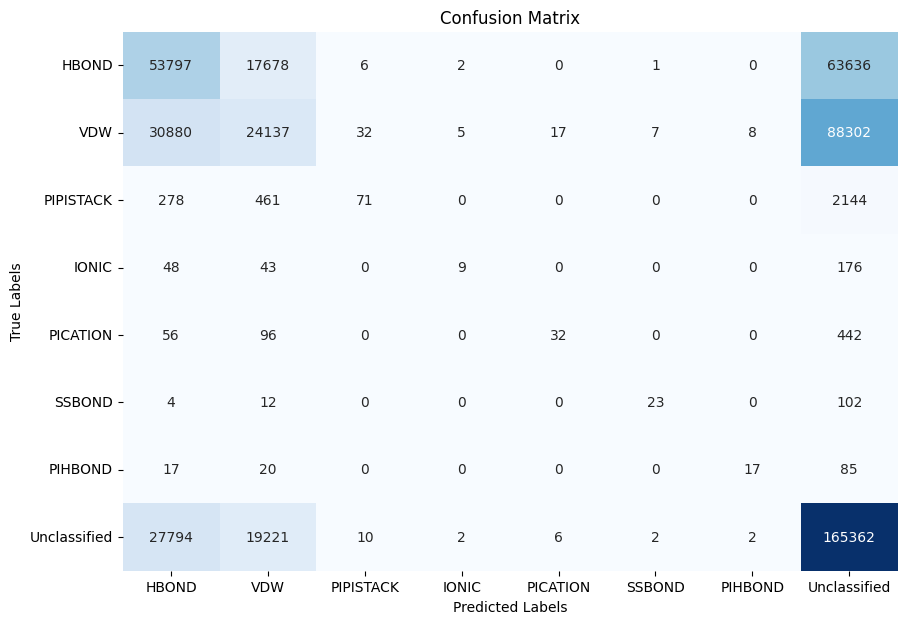


===== Feature Importance =====


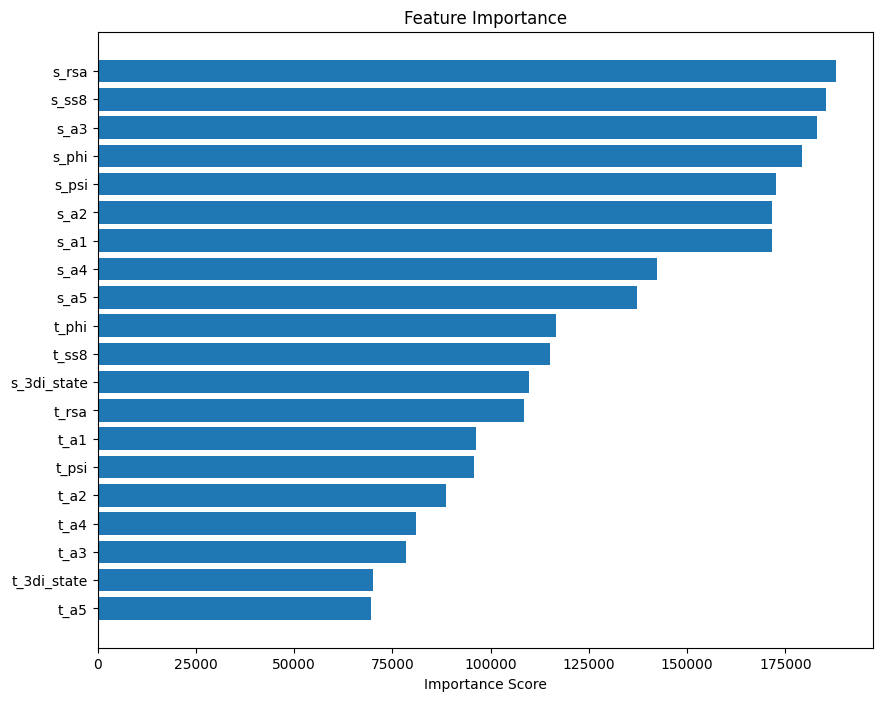

Pruned model saved to models/mcc_models_pruned_mean_threshold/xgboost_model_multiclass_pruned.json


In [ ]:
model_path = os.path.join(path, 'models/mcc_models/xgboost_model_mcc.json')
model = xgb.Booster()
model.load_model(model_path)

# Get feature importances as a dictionary
importance = model.get_score(importance_type='weight')

# Extract the importance values and calculate their mean
if importance:
    importance_values = np.array(list(importance.values()))
    threshold = np.mean(importance_values)
    print(f"Feature importance threshold: {threshold:.4f}")
else:
    print(f"Warning: No feature importance scores found for the model. Skipping feature selection.")
    # You can exit or continue with all features

# Get features sorted by importance
sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)
print(f"Total features with importance scores: {len(sorted_importance)}")

# Select features based on the threshold
selected_feature_indices = [int(key[1:]) for key, score in sorted_importance if score > threshold]

if not selected_feature_indices:
    print(f"Warning: No features selected with threshold {threshold}. Using top 10 features instead.")
    # Fallback to top N features if threshold yields no features
    selected_feature_indices = [int(key[1:]) for key, _ in sorted_importance[:10]]

# Ensure selected_feature_indices are within bounds
max_feature_index = X_train.shape[1] - 1
selected_feature_indices = [idx for idx in selected_feature_indices if idx <= max_feature_index]

print(f"Selected {len(selected_feature_indices)} features out of {X_train.shape[1]}")

# Filter training/test data using selected indices
X_train_selected = X_train[:, selected_feature_indices]
X_test_selected = X_test[:, selected_feature_indices]

# Print selected feature names if available
try:
    selected_features_names = [feature_names[idx] for idx in selected_feature_indices]
    print(f"Top 10 selected features: {selected_features_names[:10]}")
except NameError:
    print(f"Top 10 selected feature indices: {selected_feature_indices[:10]}")
    print("Cannot retrieve feature names: 'feature_names' variable not found.")

# Create DMatrix objects with multi-class labels
# Note: For multi-class, we keep the original labels (not binary)
dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
dtest_selected = xgb.DMatrix(X_test_selected, label=y_test)

# Train the pruned multi-class model
num_classes = len(np.unique(y_train))
fs_model = xgb.train(
    params={
        'device': 'cuda',
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'eval_metric': 'mlogloss',
        'max_depth': 10,
        'learning_rate': 0.1,
        'seed': 42
    },
    dtrain=dtrain_selected,
    num_boost_round=model.best_iteration + 1 if hasattr(model, 'best_iteration') else 100,
    evals=[(dtest_selected, 'eval')],
    verbose_eval=100
)

evaluate_model(fs_model, X_test, y_test, feature_names, selected_feature_indices=selected_feature_indices)

# Save the pruned model
output_dir = 'models/mcc_models_pruned_mean_threshold'
os.makedirs(output_dir, exist_ok=True)
fs_model.save_model(os.path.join(output_dir, 'xgboost_model_multiclass_pruned.json'))
print(f"Pruned model saved to {os.path.join(output_dir, 'xgboost_model_multiclass_pruned.json')}")